### Dependencies

In [1]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

### Reflect Tables into SQLAlchemy ORM

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Set engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# Reflect database
Base = automap_base()
# Reflect tables
Base.prepare(engine, reflect=True)

In [7]:
# View reflected table names
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create session 
session = Session(engine)

### Exploratory Climate Analysis

In [10]:
# Latest Date in DataFrame
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23',)

In [11]:
# Calculate the Date 1 Year Ago from the Last Data Point in the Database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [12]:
# Design a Query to Retrieve the Last 12 Months of Precipitation Data Selecting Only the `date` and `prcp` Values
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [13]:
# Perform a Query to Retrieve the Data and Precipitation Scores
all_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()

In [14]:
# Save the Query Results as a Pandas DataFrame and Set the Index to the Date Column & Sort the Dataframe Values by `date`
prcp_df = pd.DataFrame(prcp_data, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


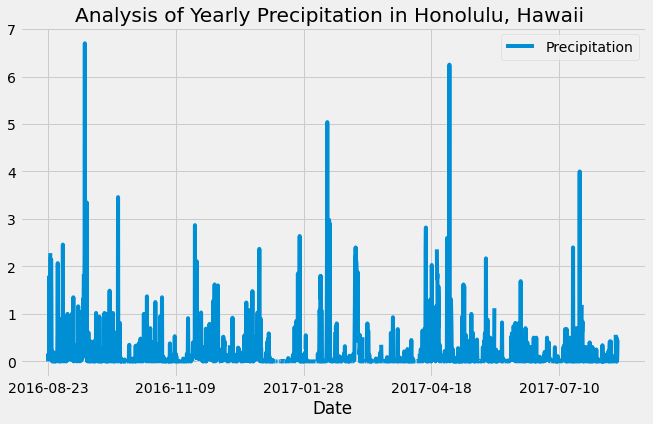

In [15]:
# Use Pandas Plotting with Matplotlib to `plot` the Data
prcp_df.plot(title="Analysis of Yearly Precipitation in Honolulu, Hawaii ", figsize=(10,6))
plt.legend(loc='upper right')
plt.show()

In [16]:
# Use Pandas to Calculate the Summary of the Precipitation Data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a Query to show the number of Stations in the Dataset
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [18]:
# Design a Query to Find the Most Active Station(s)
# List the Station(s) and Count in Descending Order
# Which Station Had the Highest Number of Observations?
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### WEATHER STATION USC00519281 HAD THE MOST OBSERVATIONS WITH 2772

In [19]:
# Using the Station ID from the Previous Query, Calculate the Lowest Temperature Recorded, 
# Highest Temperature Recorded, and Average Temperature of the Most Active Station
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

temperatures = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
temperatures

[(54.0, 85.0, 71.66378066378067)]

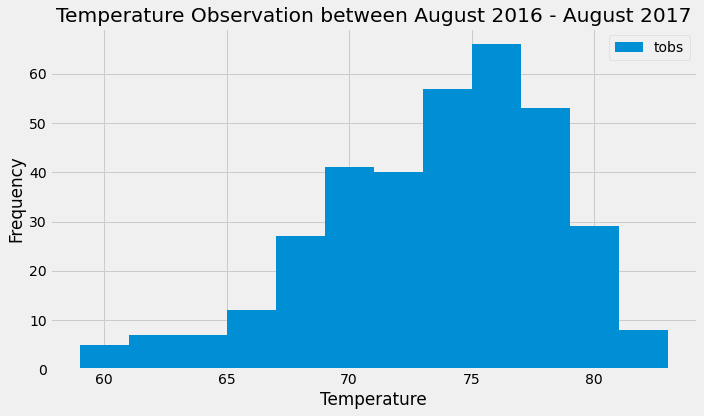

In [20]:
# Choose the Station with the Highest Number of Temperature Observations
# Design a Query to Retrieve the Last 12 Months of Temperature Observation Data for this Station
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["tobs"])

# Plot the Results as a Histogram with `bins=12`
tobs_data_df.plot.hist(bins=12, title="Temperature Observation between August 2016 - August 2017", figsize=(10,6))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### TEMPERATURE ANALYSIS

In [21]:
# This Function Called `calc_temps` Will Accept Start Date and End Date in the Format `%Y-%m-%d` 
# and Return the Minimum, Average, and Maximum Temperatures for that Range of Dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function Usage Example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use the `calc_temps` Function to Calculate the min, avg, and max Temperatures for Your Trip 
# Using the Previous Year's Data for Those Same Dates
trip_temps = calc_temps("2017-03-14", "2017-03-28")
trip_temps

[(65.0, 73.12222222222222, 80.0)]

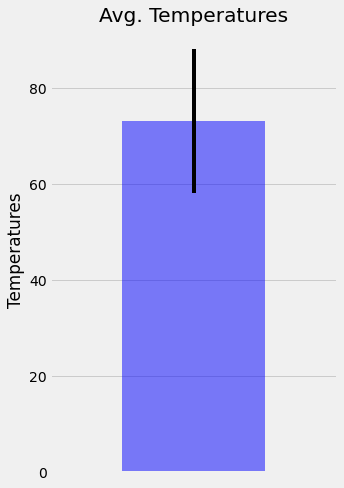

In [23]:
# Load the Results as a Pandas DataFrame
trip_temps = pd.DataFrame(trip_temps, columns=["TMIN", "TAVG", "TMAX"])

# Plot the min, avg, and max Temperatures from the Previous Query as a Bar Chart
# Use "Trip Average Temperature" as the Title
# Use the Average Temperature for the y Value
# Use the Peak-to-Peak (max-min) Value as the y Error Bar (yerr)
trip_temps.plot.bar(y="TAVG", yerr=(trip_temps["TMAX"] - trip_temps["TMIN"]), 
                    title="Avg. Temperatures", color="blue", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.ylabel("Temperatures")
plt.tight_layout()
plt.show()

In [24]:
# Query for precipitation per station on trip dates
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

station_rain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= "2017-03-14")
                   .filter(Measurement.date <= "2017-03-28")
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

# Convert Query object to df
stations_table = pd.DataFrame(np.array(station_rain))

# Rename the columns
stations_table = stations_table.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stations_table

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.3599999999999999,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",1.35,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.9500000000000001,21.4234,-157.8015,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.87,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.21,21.5213,-157.8374,7.0
5,USC00517948,"PEARL CITY, HI US",0.06,21.3934,-157.9751,11.9
6,USC00519397,"WAIKIKI 717.2, HI US",0.02,21.2716,-157.8168,3.0


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# Set the start and end date for the trip
trip_dates=['08-05','08-06','08-07','08-08','08-09',
            '08-10','08-11','08-12','08-13','08-14','08-15']

normal_temps=[]
    
def daily_normals(date):
    sel = [func.min(Measurement.tobs), 
           func.round(func.avg(Measurement.tobs),2), 
           func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

for i in trip_dates:
    normal_temps.append(daily_normals(i)[0])

normal_temps

[(69.0, 76.15, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.16, 83.0),
 (68.0, 76.56, 83.0),
 (69.0, 75.98, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98, 82.0),
 (67.0, 76.53, 83.0),
 (71.0, 76.98, 84.0),
 (71.0, 76.78, 82.0),
 (69.0, 76.47, 83.0)]

In [27]:
daily_normals = pd.DataFrame(normal_temps,columns=['min_temp','avg_temp','high_temp'],
                                   index=trip_dates)
daily_normals.index.name = 'Dates'
daily_normals

,min_temp,avg_temp,high_temp
Dates,,,
08-05,69.0,76.15,82.0
08-06,67.0,76.25,83.0
08-07,71.0,77.16,83.0
08-08,68.0,76.56,83.0
08-09,69.0,75.98,81.0
08-10,65.0,76.42,83.0
08-11,67.0,75.98,82.0
08-12,67.0,76.53,83.0
08-13,71.0,76.98,84.0


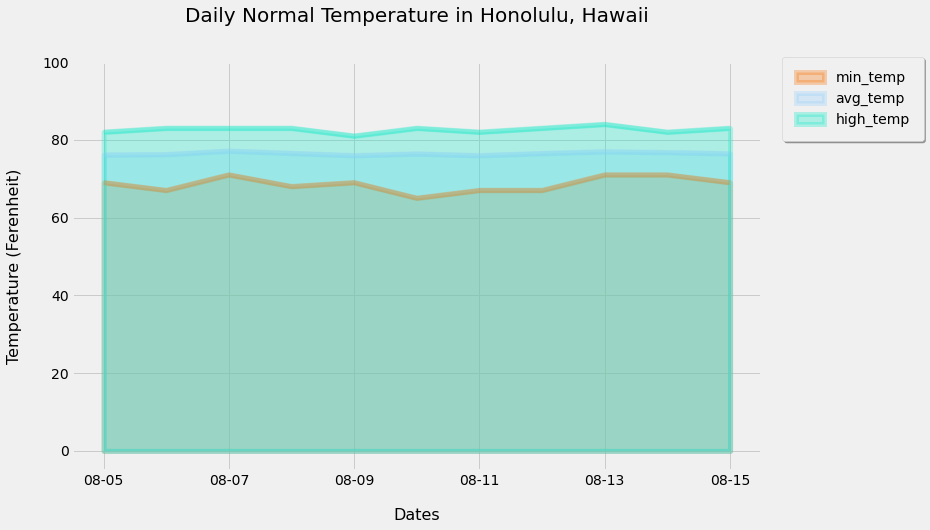

In [28]:
# Plot with Pandas
plt.rcParams['figure.figsize']=(11,7)
colors=['xkcd:orange','xkcd:light blue','xkcd:aqua']
daily_normals.plot.area(linewidth=5,stacked=False,rot=0,alpha=0.3,color=colors);

plt.ylim(-5,100)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.xlabel('Dates',fontsize=16,color='black',labelpad=20)
plt.ylabel('Temperature (Ferenheit)',fontsize=16,color='black',labelpad=20)
plt.title('Daily Normal Temperature in Honolulu, Hawaii',fontsize=20,pad=40)
plt.gca().legend(loc='center left', bbox_to_anchor=(1.02, 0.91),shadow=True,borderpad=1);# Pl